<a href="https://colab.research.google.com/github/nikshanpatel/CS634-DataMiningProject-1/blob/master/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJECT**: **[Google Analytics Customer Revenue Prediction](https://www.kaggle.com/c/ga-customer-revenue-prediction/overview)**

#### **The fundamental steps we will be taking in this project are:**


>1.   **Understand the Objective of this project**
2.   **Data Collection & Data Preperation**
3.   **Modeling & Evaluation**
4.   **Communicate/Present Results**


# **1 - Understanding the Objective**
---

### **Predict how much GStore customers will spend**

In this [Project](https://www.kaggle.com/c/ga-customer-revenue-prediction/overview), we’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to **predict revenue per customer**.
 
**What are we predicting?**

We are predicting the natural log of the sum of all transactions per user.

**Evaluation Metric**

***`RMSE`*** - *Root Mean Squared Error*

**RMSE** is the standard deviation of residuals (predictions errors). When we scatter plot the target_test values and predictions, the RMSE tells us how concentrated are those points around the line of best fit.

![RSME](./rsme.jpg)


# **2 - Data Collection & Data Preperation**
---

## **Mount** the **Google** **Drive** on to the Notebook.


---

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# to load kaggle API
!pip install -q kaggle 
from google.colab import files 
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
#now we install 7zip
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [0]:
!kaggle datasets download -d niteshmistry/minigacustomerrevenueprediction

minigacustomerrevenueprediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!7za e minigacustomerrevenueprediction.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 16767918 bytes (16 MiB)

Extracting archive: minigacustomerrevenueprediction.zip
--
Path = minigacustomerrevenueprediction.zip
Type = zip
Physical Size = 16767918

  0%    
Would you like to replace the existing file:
  Path:     ./mini-test.csv
  Size:     33552335 bytes (32 MiB)
  Modified: 2019-11-02 19:51:56
with the file from archive:
  Path:     mini-test.csv
  Size:     33552335 bytes (32 MiB)
  Modified: 2019-11-02 19:51:56
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? y

  0% - mini-test.csv                    
Would you like to replace the existing file:
  Path:     ./mini-train.csv
  Size:     325178219 bytes (311 MiB)
  Modified: 

## **Import** the necessary **libraries** that are required to run this notebook:
---
>1. **JSON**
2. **Pandas**
3. **NumPy**
4. **MatPlotLib**
5. **Plotly**  - Plot graphs
6. **SKLearn** - For model selection, preprocessing, metrics



In [0]:
import os
import time
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn import linear_model
from sklearn.model_selection import train_test_split

%matplotlib inline


## **Datasets** that are required for this project that are necessary to run the notebook :
---
>1. **TRAIN Dataset** - *`train.csv`* (315 MB)
2. **TEST Dataset** - *`test.csv`* (32 MB)

### Each row in the dataset is one visit to the store. We are predicting the natural log of the sum of all transactions per user.

## The **data fields** in the given files are

* **fullVisitorId**- A unique identifier for each user of the Google Merchandise Store.
* **channelGrouping** - The channel via which the user came to the Store.
* **date** - The date on which the user visited the Store.
* **device** - The specifications for the device used to access the Store.
* **geoNetwork** - This section contains information about the geography of the user.
* **sessionId** - A unique identifier for this visit to the store.
* **socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* **totals** - This section contains aggregate values across the session.
* **trafficSource** - This section contains information about the Traffic Source from which the session originated.
* **visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* **visitNumber** - The session number for this user. If this is the first session, then this is set to 1.
* **visitStartTime** - The timestamp (expressed as POSIX time).

***NOTE***: Some of the fields are in json format. We will have to transform them into Dataframe


## **LOAD** the data files that are required:
---

In [0]:
TRAIN_FILE = '/content/mini-train.csv'
TEST_FILE = '/content/mini-test.csv'

#------------------------------------------------------------------------------------------------
# COMMON CSV DATA FILE LOADER - RETURN DATAFRAME
#------------------------------------------------------------------------------------------------

def convertCSVtoDF(csv_path, nrows):

    df = pd.read_csv(csv_path, dtype={"fullVisitorId": "str"}, nrows=nrows)
    print(f"LOADED: {os.path.basename(csv_path)}   SHAPE: {df.shape}")
    
    return df

#------------------------------------------------------------------------------------------------
# LOAD TRAINING DATASET file into DATAFRAME
#------------------------------------------------------------------------------------------------
train_df = convertCSVtoDF(TRAIN_FILE,None)
test_df = convertCSVtoDF(TEST_FILE,None)

#------------------------------------------------------------------------------------------------
# LISTING HEADERS AND SAMPLE RECORDS (5)
#------------------------------------------------------------------------------------------------
print("\n")
print(train_df.columns)


LOADED: mini-train.csv   SHAPE: (20000, 59)
LOADED: mini-test.csv   SHAPE: (2000, 59)


Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bo

In [0]:
#------------------------------------------------------------------------------------------------
# FUNCTION REMOVING EMPTY COLUMNS with value "not available in demo dataset"
#------------------------------------------------------------------------------------------------

def removeUselessColumns(df):
  EMPTY_COLUMNS = []

  dataframe = df

  for column in train_df.columns:
    if train_df[column][0] == 'not available in demo dataset':
      EMPTY_COLUMNS.append(column)
  
  print("DATAFRAME IS " + str(len(dataframe.columns)) + " COLUMNS...")
  print("FOUND " + str(len(EMPTY_COLUMNS)) + " USELESS COLUMNS...")
  print("COLUMNS:  " + str(EMPTY_COLUMNS))
  print("REMOVING " + str(len(EMPTY_COLUMNS)) + " COLUMNS...")
  dataframe.drop(EMPTY_COLUMNS, axis=1, inplace=True)
  print("DATAFRAME IS NOW " + str(len(dataframe.columns)) + " COLUMNS...")

  return dataframe




**REMOVE USELESS COLUMNS** that has values "**NOT AVAILABLE IN DEMO DATASET**

In [0]:
#------------------------------------------------------------------------------------------------
# TRAINING DATAFRAME - REMOVING EMPTY COLUMNS with value "not available in demo dataset"
#------------------------------------------------------------------------------------------------

train_df = removeUselessColumns(train_df)
train_df.head(5)

DATAFRAME IS 59 COLUMNS...
FOUND 20 USELESS COLUMNS...
COLUMNS:  ['device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.city', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro', 'geoNetwork.networkLocation', 'geoNetwork.region', 'trafficSource.adwordsClickInfo.criteriaParameters']
REMOVING 20 COLUMNS...
DATAFRAME IS NOW 39 COLUMNS...


,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.continent,geoNetwork.country,geoNetwork.networkDomain,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,desktop,False,Windows,Europe,Germany,(not set),Western Europe,1.0,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Americas,United States,(not set),Northern America,NaN,2,NaN,2.0,2.0,28.0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,mobile,True,Android,Americas,United States,windjammercable.net,Northern America,NaN,2,1.0,2.0,1.0,38.0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct)
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,desktop,False,Windows,Asia,Turkey,unknown.unknown,Western Asia,NaN,2,1.0,2.0,1.0,1.0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,desktop,False,Windows,Americas,Mexico,prod-infinitum.com.mx,Central America,NaN,2,1.0,2.0,1.0,52.0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [0]:
train_df.describe()

,date,visitId,visitNumber,visitStartTime,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adwordsClickInfo.page
count,2.000000e+04,2.000000e+04,20000.000000,2.000000e+04,9873.0,20000.000000,15088.0,19999.000000,9120.000000,10101.000000,1.930000e+02,1.930000e+02,196.000000,20000.0,630.000000
mean,2.017041e+07,1.498277e+09,2.264200,1.498277e+09,1.0,4.794450,1.0,3.971549,4.456140,264.244629,1.278192e+08,1.087636e+08,1.040816,1.0,1.023810
std,4.737638e+03,1.565797e+07,7.876636,1.565797e+07,0.0,9.080243,0.0,6.498605,12.593541,459.176173,2.432262e+08,1.711924e+08,0.222727,0.0,0.172159
min,2.016090e+07,1.472799e+09,1.000000,1.472800e+09,1.0,1.000000,1.0,1.000000,1.000000,1.000000,4.990000e+06,1.990000e+06,1.000000,1.0,1.000000
25%,2.017020e+07,1.486118e+09,1.000000,1.486118e+09,1.0,1.000000,1.0,1.000000,1.000000,35.000000,2.799000e+07,2.102000e+07,1.000000,1.0,1.000000
50%,2.017062e+07,1.498247e+09,1.000000,1.498247e+09,1.0,2.000000,1.0,2.000000,1.000000,94.000000,5.171000e+07,4.458000e+07,1.000000,1.0,1.000000
75%,2.017113e+07,1.512038e+09,1.000000,1.512038e+09,1.0,5.000000,1.0,4.000000,1.000000,270.000000,1.141600e+08,1.087200e+08,1.000000,1.0,1.000000
max,2.018042e+07,1.523862e+09,401.000000,1.523862e+09,1.0,229.000000,1.0,165.000000,96.000000,5553.000000,2.103690e+09,1.171470e+09,3.000000,1.0,3.000000


In [0]:
train_df['date'].head()

0    20171016
1    20171016
2    20171016
3    20171016
4    20171016
Name: date, dtype: int64

In [0]:
#------------------------------------------------------------------------------------------------
# TESTING DATAFRAME - REMOVING EMPTY COLUMNS with value "not available in demo dataset"
#------------------------------------------------------------------------------------------------
test_df = removeUselessColumns(test_df)


DATAFRAME IS 59 COLUMNS...
FOUND 0 USELESS COLUMNS...
COLUMNS:  []
REMOVING 0 COLUMNS...
DATAFRAME IS NOW 59 COLUMNS...


In [0]:
test_df.head(5)

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,1526099341,2,1526099341,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,Asia,India,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Delhi,Southern Asia,NaN,4,NaN,3.0,1,973.0,NaN,NaN,NaN,1,(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,1526064483,166,1526064483,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,San Francisco,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,4,NaN,3.0,1,49.0,NaN,NaN,NaN,1,(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),True,(not set),(none),(not set),(direct)
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,3461808543879602873,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",Not Socially Engaged,1526067157,2,1526067157,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,onlinecomputerworks.com,not available in demo dataset,not available in demo dataset,Nort

In [0]:
test_df.describe()

,date,visitId,visitNumber,visitStartTime,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adwordsClickInfo.page
count,2000.0,2.000000e+03,2000.000000,2.000000e+03,1400.0,2000.000000,1444.0,1999.000000,2000.000000,597.000000,3.100000e+01,3.100000e+01,31.0,2000.0,3.0
mean,20180511.0,1.526062e+09,2.586000,1.526062e+09,1.0,5.063500,1.0,3.865433,5.054000,356.514238,1.566197e+08,1.520068e+08,1.0,1.0,1.0
std,0.0,2.185853e+04,9.711424,2.185514e+04,0.0,8.766749,0.0,6.237893,13.764658,527.043185,2.389345e+08,2.385346e+08,0.0,0.0,0.0
min,20180511.0,1.526021e+09,1.000000,1.526022e+09,1.0,1.000000,1.0,1.000000,1.000000,1.000000,3.750000e+06,1.750000e+06,1.0,1.0,1.0
25%,20180511.0,1.526045e+09,1.000000,1.526045e+09,1.0,1.000000,1.0,1.000000,1.000000,74.000000,2.509000e+07,2.138500e+07,1.0,1.0,1.0
50%,20180511.0,1.526060e+09,1.000000,1.526060e+09,1.0,1.000000,1.0,1.000000,1.000000,168.000000,5.597000e+07,5.097000e+07,1.0,1.0,1.0
75%,20180511.0,1.526078e+09,2.000000,1.526078e+09,1.0,6.000000,1.0,4.000000,1.000000,390.000000,1.344700e+08,1.309700e+08,1.0,1.0,1.0
max,20180511.0,1.526108e+09,195.000000,1.526108e+09,1.0,87.000000,1.0,67.000000,94.000000,5268.000000,1.082500e+09,1.076500e+09,1.0,1.0,1.0


**Impute 0 for ALL missing target values (totals.transactionRevenue)**

## Check Missing Data

In [0]:
# checking missing data
miss_per = {}
for k, v in dict(train_df.isna().sum(axis=0)).items():
    if v == 0:
        continue
    miss_per[k] = 100 * float(v) / len(train_df)
miss_per

{'totals.bounces': 50.635,
 'totals.newVisits': 24.56,
 'totals.pageviews': 0.005,
 'totals.sessionQualityDim': 54.4,
 'totals.timeOnSite': 49.495,
 'totals.totalTransactionRevenue': 99.035,
 'totals.transactionRevenue': 99.035,
 'totals.transactions': 99.02,
 'trafficSource.adContent': 97.395,
 'trafficSource.adwordsClickInfo.adNetworkType': 96.85,
 'trafficSource.adwordsClickInfo.gclId': 96.835,
 'trafficSource.adwordsClickInfo.isVideoAd': 96.85,
 'trafficSource.adwordsClickInfo.page': 96.85,
 'trafficSource.adwordsClickInfo.slot': 96.85,
 'trafficSource.isTrueDirect': 68.335,
 'trafficSource.keyword': 66.05,
 'trafficSource.referralPath': 69.48}

In [0]:
#train_df["totals.transactionRevenue"].fillna(0, inplace=True)
#test_df["totals.transactionRevenue"].fillna(0, inplace=True)

**Remove columns that are in TRAINING which are not there in TEST**

In [0]:
print("Columns not in TEST but in TRAIN : ", set(train_df.columns).difference(set(test_df.columns)))

Columns not in TEST but in TRAIN :  set()


# **3 - MODELING & EVALUTATION**
---

 
 
Since we are predicting the natural log of sum of all transactions of the user, let us sum up the transaction revenue at user level and take a log and then do a scatter plot.


First we have to change the datatype to 'FLOAT' to make sure the value is a dollar value

In [0]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')

Next we have to group the USER level transaction to by using the GROUPBY function on the dataframe. This will give us the Total Transaction Value for given user. 

In [0]:
grouped_df_sum = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
grouped_df_sum.sort_values(by=['totals.transactionRevenue'], inplace=True, ascending=False)
grouped_df_sum

,fullVisitorId,totals.transactionRevenue
3257,1814166460229302850,1.171470e+09
14060,7638336411447332495,1.077000e+09
5602,309482894121265066,9.004300e+08
5704,3152246617474456269,6.355000e+08
13149,7168226225550508027,5.939100e+08
...,...,...
6163,3396397804735366613,0.000000e+00
6164,3396461882036302761,0.000000e+00
6165,3396775680310832137,0.000000e+00
6166,3398101758099870675,0.000000e+00


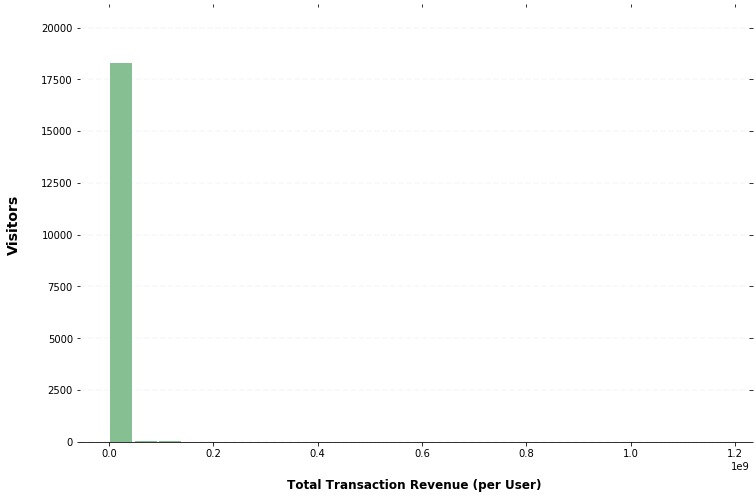

In [0]:
ax = grouped_df_sum.hist('totals.transactionRevenue', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Total Transaction Revenue (per User)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Visitors", labelpad=20, weight='bold', size=14)



In [0]:
grouped_df_count = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].count().reset_index()
grouped_df_count.sort_values(by=['totals.transactionRevenue'], inplace=True, ascending=False)
grouped_df_count

,fullVisitorId,totals.transactionRevenue
7422,4064008221273566105,2
5615,3102343581929921848,2
18129,987390821892515431,2
830,0463325773564352787,2
13763,747690048733385763,1
...,...,...
6163,3396397804735366613,0
6164,3396461882036302761,0
6165,3396775680310832137,0
6166,3398101758099870675,0


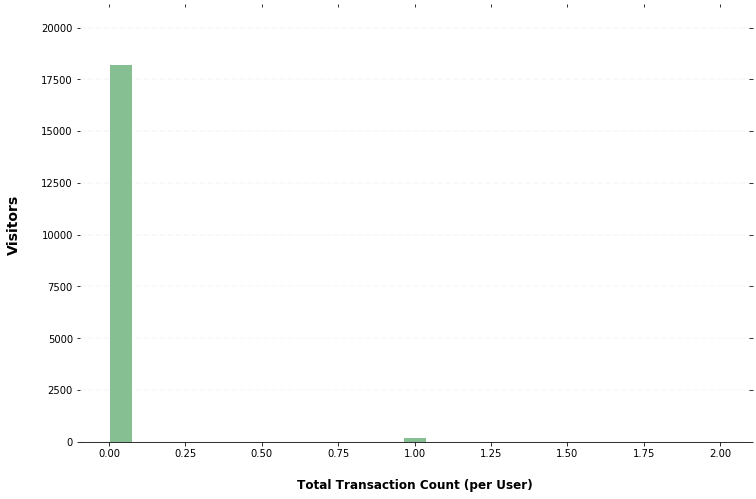

In [0]:
ax = grouped_df_count.hist('totals.transactionRevenue', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Total Transaction Count (per User)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Visitors", labelpad=20, weight='bold', size=14)



## **numpy.log1p() in Python**
**numpy.log1p(arr, out = None, *, where = True, casting = ‘same_kind’, order = ‘K’, dtype = None, ufunc ‘log1p’) :**

This mathematical function helps user to calculate **natural logarithmic value of x+1** where x belongs to all the input array elements.

* **log1p is reverse of exp(x) – 1.**


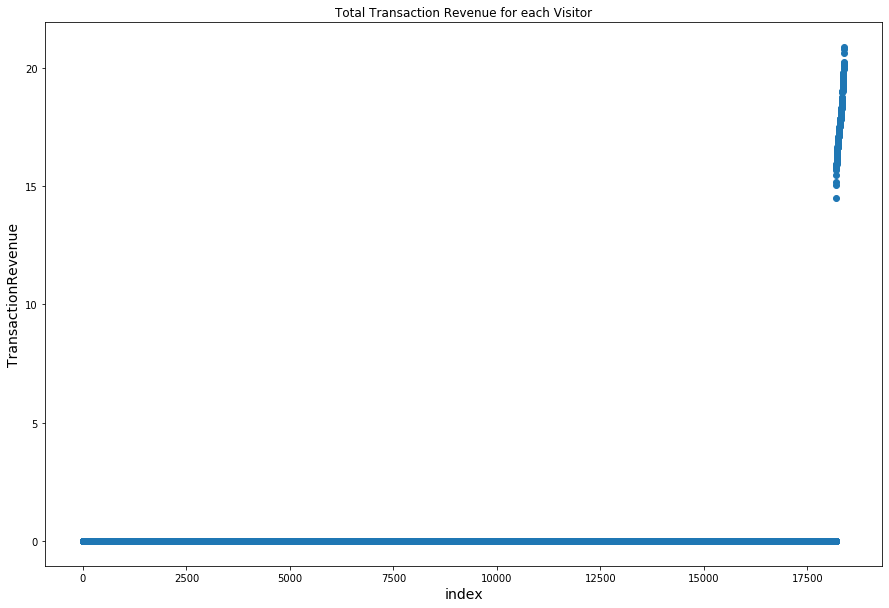

In [0]:
plt.figure(figsize=(15,10))
plt.scatter(range(grouped_df_sum.shape[0]), np.sort(np.log1p(grouped_df_sum["totals.transactionRevenue"].values)))
plt.title('Total Transaction Revenue for each Visitor')
plt.xlabel('index', fontsize=14)
plt.ylabel('TransactionRevenue', fontsize=14)
plt.show()

In [0]:
non_zero_instance = pd.notnull(train_df["totals.transactionRevenue"]).sum()
print("Number of instances in train set with non-zero revenue : ", non_zero_instance, " and ratio is : ", non_zero_instance / train_df.shape[0])
non_zero_revenue = (grouped_df_sum["totals.transactionRevenue"]>0).sum()
print("Number of unique customers with non-zero revenue : ", non_zero_revenue, "and the ratio is : ", non_zero_revenue / train_df.shape[0])

Number of instances in train set with non-zero revenue :  193  and ratio is :  0.00965
Number of unique customers with non-zero revenue :  189 and the ratio is :  0.00945


In [44]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  18384  out of rows :  20000
Number of unique visitors in test set :  1855  out of rows :  2000
Number of common visitors in train and test set :  7


Charting the Transactions and Revenue per Date